In [11]:
# Import libraries
import os
import time
import shutil
import pathlib
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adamax

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Load dataset paths and labels
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    for file in os.listdir(foldpath):
        filepaths.append(os.path.join(foldpath, file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [14]:
# Split data
train_df, dummy_df = train_test_split(df, train_size=0.75, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, random_state=123)

In [15]:
# ImageDataGenerator setup
img_size = (224, 224)
batch_size = 32
img_shape = (img_size[0], img_size[1], channels)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 3912 validated image filenames belonging to 2 classes.
Found 782 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


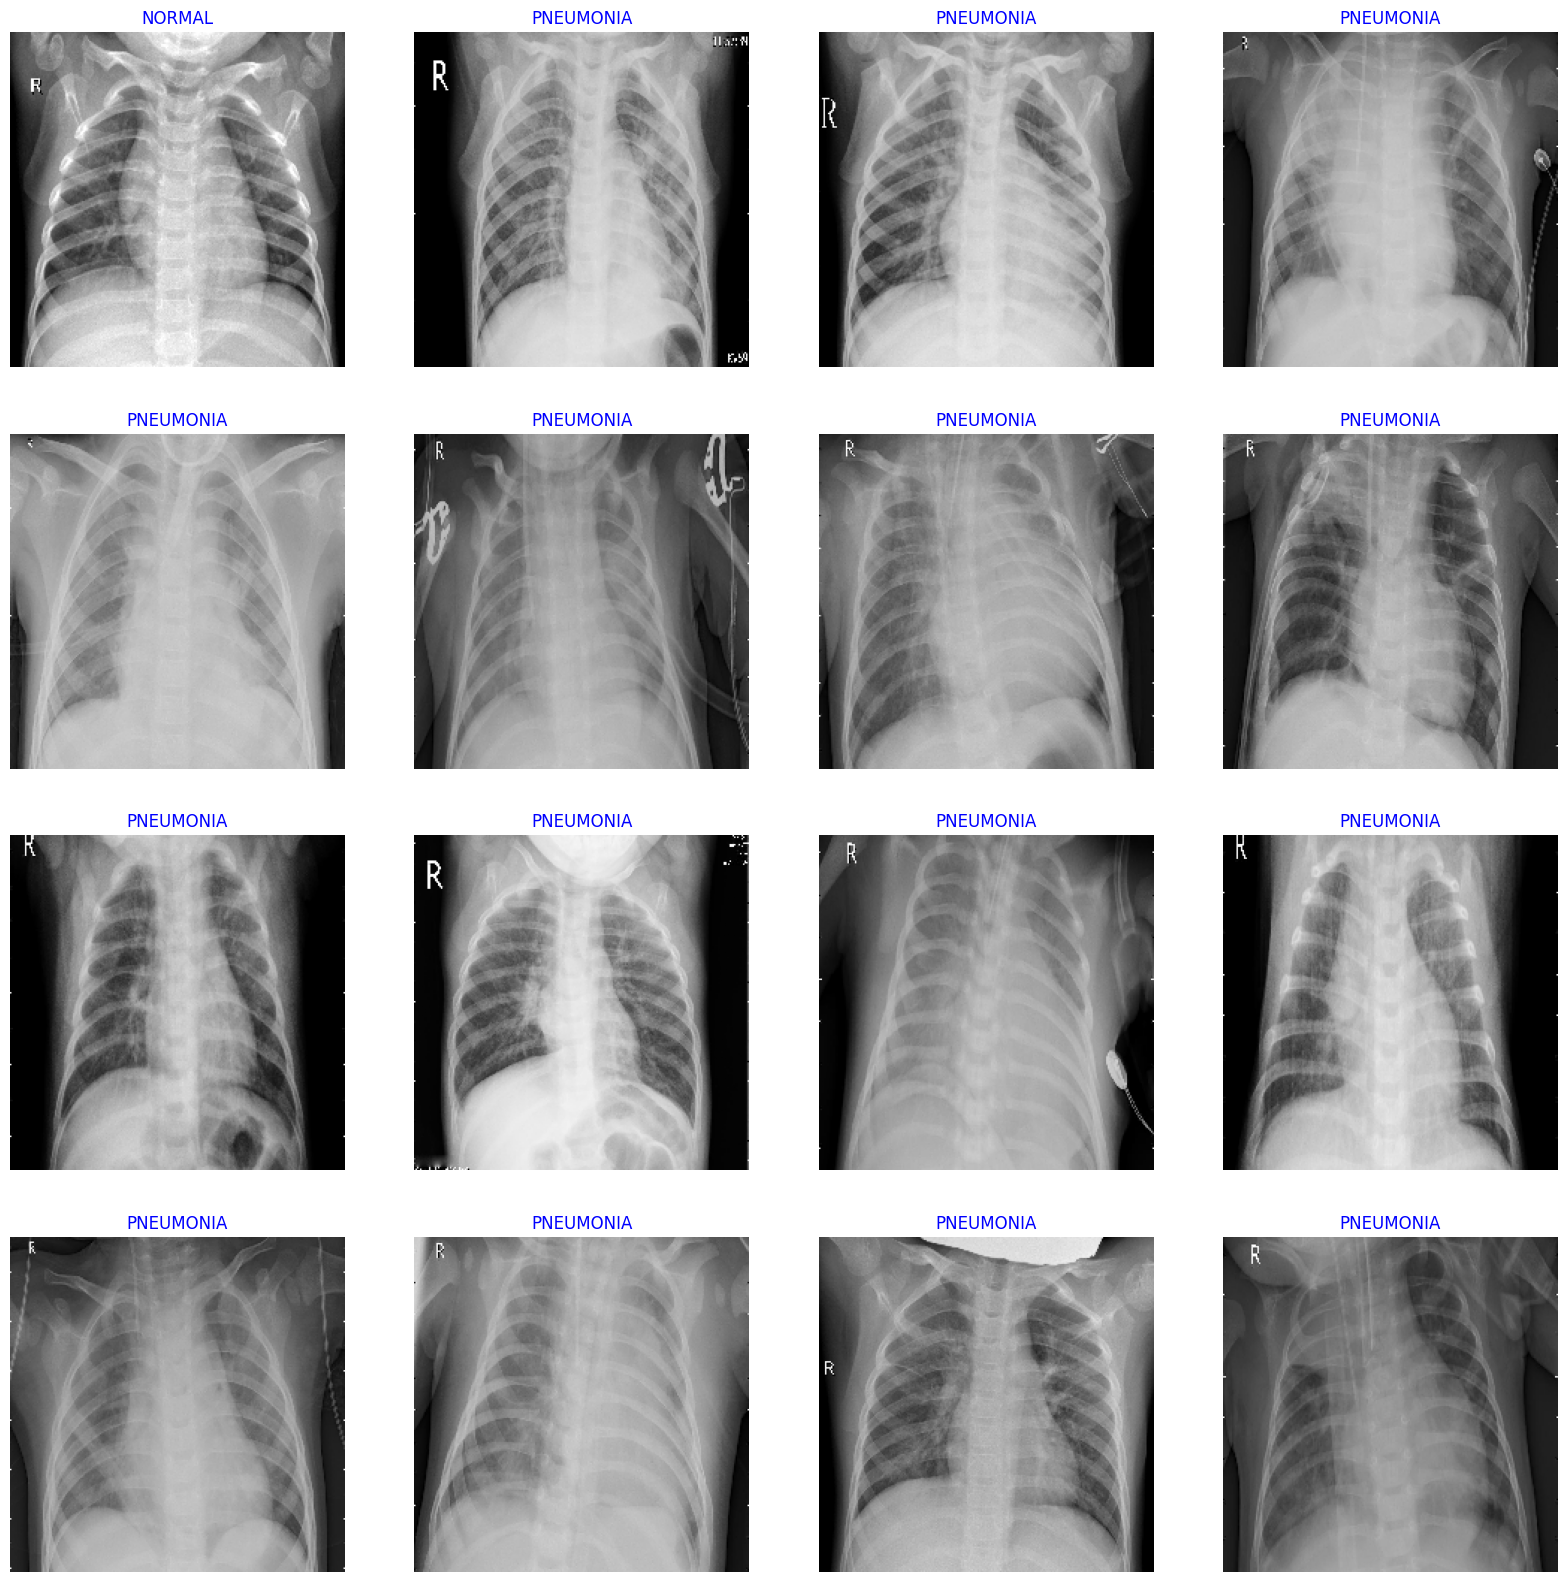

In [16]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys()) 

images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [22]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Model setup using VGG19
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='dense_1'),
    Dropout(0.5, name='dropout'),
    Dense(2, activation='softmax', name='output')  # For binary classification
])

model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
batch_size = 32   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10


I0000 00:00:1719622168.460696      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719622168.487377      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7423 - loss: 1.8298

W0000 00:00:1719622255.509962      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.7428 - loss: 1.8207

W0000 00:00:1719622258.025212      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 198s 940ms/step - accuracy: 0.7433 - loss: 1.8117 - val_accuracy: 0.8964 - val_loss: 0.2427
Epoch 2/10


W0000 00:00:1719622283.588322      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 501ms/step - accuracy: 0.9088 - loss: 0.2226 - val_accuracy: 0.8977 - val_loss: 0.2620
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 503ms/step - accuracy: 0.9337 - loss: 0.1708 - val_accuracy: 0.9604 - val_loss: 0.1131
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 501ms/step - accuracy: 0.9571 - loss: 0.1162 - val_accuracy: 0.9169 - val_loss: 0.2289
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 504ms/step - accuracy: 0.9602 - loss: 0.0976 - val_accuracy: 0.9642 - val_loss: 0.0994
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 502ms/step - accuracy: 0.9736 - loss: 0.0741 - val_accuracy: 0.9552 - val_loss: 0.1095
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 503ms/step - accuracy: 0.9582 - loss: 0.1021 - val_accuracy: 0.9770 - val_loss: 0.0775
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 63s 507ms/step - accuracy: 0.9782 - loss: 0.0573 - val_accuracy: 0.9757 - val_loss: 0.0658
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 63s 508ms/step - accuracy: 0.9875 - loss: 0.0424 - val

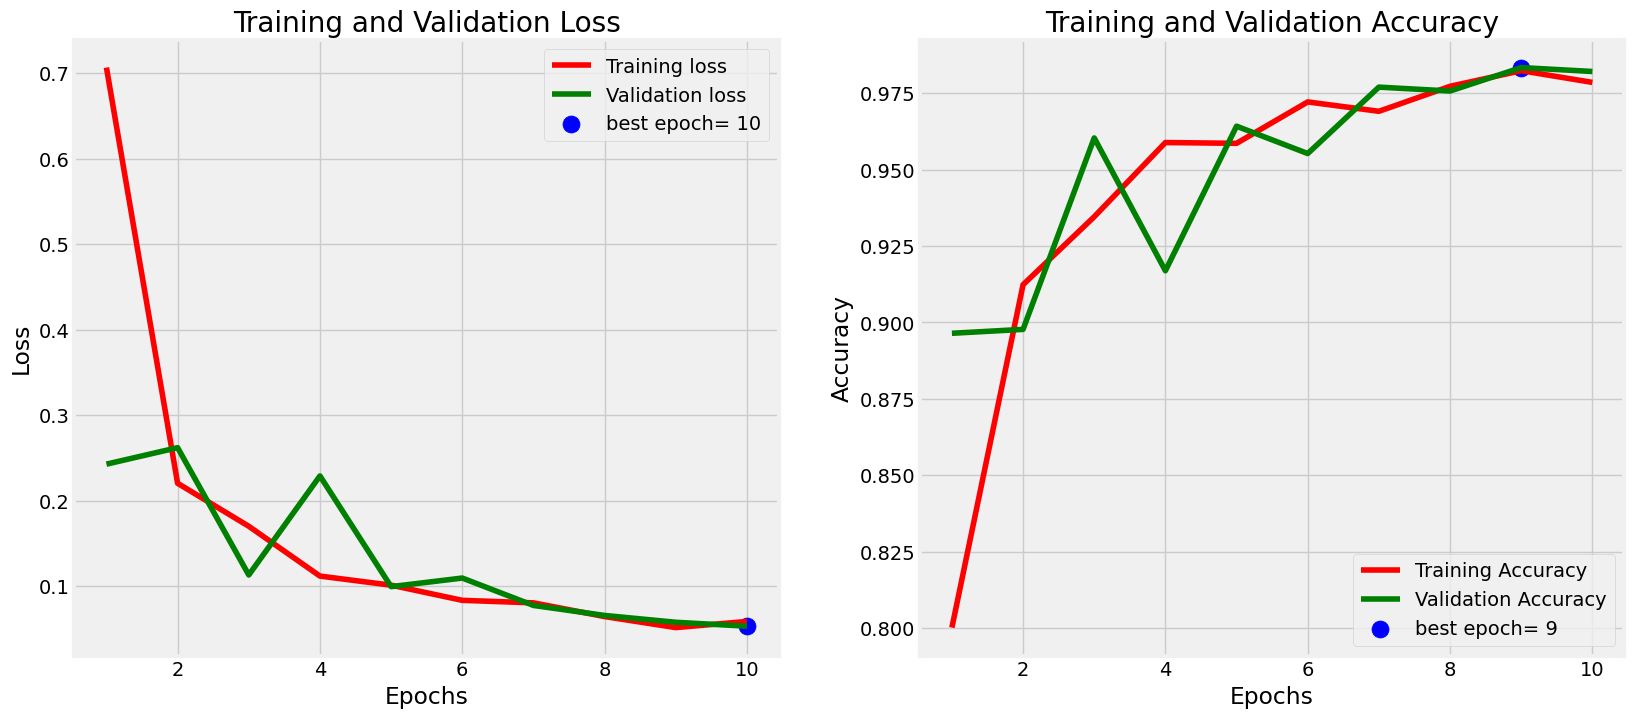

In [24]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [25]:
# Evaluate model
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 293ms/step - accuracy: 0.9869 - loss: 0.0402


W0000 00:00:1719623104.369401      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.9833 - loss: 0.0598
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9637 - loss: 0.0847 
Train Loss:  0.0431438572704792
Train Accuracy:  0.984151303768158
--------------------
Validation Loss:  0.05319281667470932
Validation Accuracy:  0.9820972084999084
--------------------
Test Loss:  0.09728284180164337
Test Accuracy:  0.961685836315155


W0000 00:00:1719623131.551771      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [29]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# If needed, get the true labels for comparison
y_true = test_gen.classes

# If necessary, print out some predictions
print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

 2/17 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step

W0000 00:00:1719623352.627643      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step
Predicted labels: [1 1 1 1 1 1 1 0 1 1]
True labels: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


W0000 00:00:1719623357.425221      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


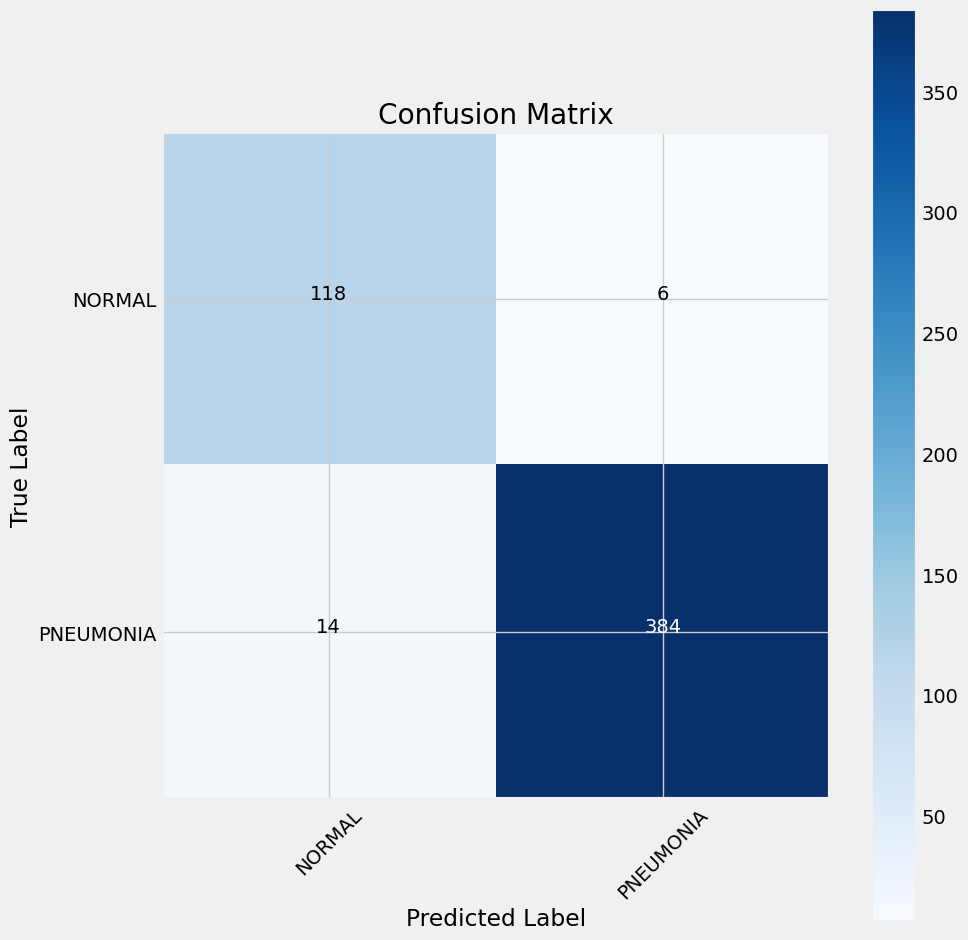

In [30]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.89      0.95      0.92       124
   PNEUMONIA       0.98      0.96      0.97       398

    accuracy                           0.96       522
   macro avg       0.94      0.96      0.95       522
weighted avg       0.96      0.96      0.96       522



In [32]:
model.save('super.h5')